In [26]:
%matplotlib inline
import copy
import glob
import errno
import pickle
import random
import os.path
import time
import calendar
import numpy
import pandas
import netCDF4
import keras
from sklearn.metrics import auc as scikit_learn_auc
import matplotlib.pyplot as pyplot
from module_4 import roc_curves
from module_4 import performance_diagrams
from module_4 import attributes_diagrams

In [27]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [28]:
DEFAULT_IMAGE_DIR_NAME = (
    '/home/ryan.lagerquist/Downloads/ams2019_short_course/'
    'track_data_ncar_ams_3km_nc_small')
DEFAULT_FEATURE_DIR_NAME = (
    '/home/ryan.lagerquist/Downloads/ams2019_short_course/'
    'track_data_ncar_ams_3km_csv_small')
DEFAULT_OUTPUT_DIR_NAME = '/home/ryan.lagerquist/Downloads/ams2019_short_course'

FIGURE_WIDTH_INCHES = 15
FIGURE_HEIGHT_INCHES = 15
FIGURE_RESOLUTION_DPI = 300

BAR_GRAPH_FACE_COLOUR = numpy.array([166, 206, 227], dtype=float) / 255
BAR_GRAPH_EDGE_COLOUR = numpy.full(3, 0.)
BAR_GRAPH_EDGE_WIDTH = 2.

FONT_SIZE = 30
pyplot.rc('font', size=FONT_SIZE)
pyplot.rc('axes', titlesize=FONT_SIZE)
pyplot.rc('axes', labelsize=FONT_SIZE)
pyplot.rc('xtick', labelsize=FONT_SIZE)
pyplot.rc('ytick', labelsize=FONT_SIZE)
pyplot.rc('legend', fontsize=FONT_SIZE)
pyplot.rc('figure', titlesize=FONT_SIZE)

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

DATE_FORMAT = '%Y%m%d'
DATE_FORMAT_REGEX = '[0-9][0-9][0-9][0-9][0-1][0-9][0-3][0-9]'

CSV_METADATA_COLUMNS = [
    'Step_ID', 'Track_ID', 'Ensemble_Name', 'Ensemble_Member', 'Run_Date',
    'Valid_Date', 'Forecast_Hour', 'Valid_Hour_UTC'
]

CSV_EXTRANEOUS_COLUMNS = [
    'Duration', 'Centroid_Lon', 'Centroid_Lat', 'Centroid_X', 'Centroid_Y',
    'Storm_Motion_U', 'Storm_Motion_V', 'Matched', 'Max_Hail_Size',
    'Num_Matches', 'Shape', 'Location', 'Scale'
]

CSV_TARGET_NAME = 'RVORT1_MAX-future_max'
TARGET_NAME = 'max_future_vorticity_s01'

NETCDF_REFL_NAME = 'REFL_COM_curr'
NETCDF_TEMP_NAME = 'T2_curr'
NETCDF_U_WIND_NAME = 'U10_curr'
NETCDF_V_WIND_NAME = 'V10_curr'
NETCDF_PREDICTOR_NAMES = [
    NETCDF_REFL_NAME, NETCDF_TEMP_NAME, NETCDF_U_WIND_NAME, NETCDF_V_WIND_NAME
]

REFLECTIVITY_NAME = 'reflectivity_dbz'
TEMPERATURE_NAME = 'temperature_kelvins'
U_WIND_NAME = 'u_wind_m_s01'
V_WIND_NAME = 'v_wind_m_s01'
PREDICTOR_NAMES = [
    REFLECTIVITY_NAME, TEMPERATURE_NAME, U_WIND_NAME, V_WIND_NAME
]

NETCDF_TRACK_ID_NAME = 'track_id'
NETCDF_TRACK_STEP_NAME = 'track_step'
NETCDF_TARGET_NAME = 'RVORT1_MAX_future'

NUM_VALUES_KEY = 'num_values'
MEAN_VALUE_KEY = 'mean_value'
MEAN_OF_SQUARES_KEY = 'mean_of_squares'

STORM_IDS_KEY = 'storm_ids'
STORM_STEPS_KEY = 'storm_steps'
PREDICTOR_NAMES_KEY = 'predictor_names'
PREDICTOR_MATRIX_KEY = 'predictor_matrix'
TARGET_NAME_KEY = 'target_name'
TARGET_MATRIX_KEY = 'target_matrix'

L1_WEIGHT = 0.
L2_WEIGHT = 0.001
NUM_PREDICTORS_TO_FIRST_NUM_FILTERS = 8
NUM_CONV_LAYER_SETS = 2
NUM_CONV_LAYERS_PER_SET = 2
NUM_CONV_FILTER_ROWS = 3
NUM_CONV_FILTER_COLUMNS = 3
CONV_LAYER_DROPOUT_FRACTION = None
USE_BATCH_NORMALIZATION = True
SLOPE_FOR_RELU = 0.2
NUM_POOLING_ROWS = 2
NUM_POOLING_COLUMNS = 2
NUM_DENSE_LAYERS = 3
DENSE_LAYER_DROPOUT_FRACTION = 0.5

MIN_LOSS_DECR_FOR_EARLY_STOPPING = 0.005
NUM_EPOCHS_FOR_EARLY_STOPPING = 5

# LIST_OF_METRIC_FUNCTIONS = [
#     keras_metrics.accuracy, keras_metrics.binary_accuracy,
#     keras_metrics.binary_csi, keras_metrics.binary_frequency_bias,
#     keras_metrics.binary_pod, keras_metrics.binary_pofd,
#     keras_metrics.binary_peirce_score, keras_metrics.binary_success_ratio,
#     keras_metrics.binary_focn
# ]

TRAINING_FILES_KEY = 'training_file_names'
NORMALIZATION_DICT_KEY = 'normalization_dict'
BINARIZATION_THRESHOLD_KEY = 'binarization_threshold'
NUM_EXAMPLES_PER_BATCH_KEY = 'num_examples_per_batch'
NUM_TRAINING_BATCHES_KEY = 'num_training_batches_per_epoch'
VALIDATION_FILES_KEY = 'validation_file_names'
NUM_VALIDATION_BATCHES_KEY = 'num_validation_batches_per_epoch'

MIN_PROBABILITY = 1e-15
MAX_PROBABILITY = 1. - MIN_PROBABILITY

PERMUTED_PREDICTORS_KEY = 'permuted_predictor_name_by_step'
HIGHEST_COSTS_KEY = 'highest_cost_by_step'
ORIGINAL_COST_KEY = 'original_cost'
STEP1_PREDICTORS_KEY = 'predictor_names_step1'
STEP1_COSTS_KEY = 'costs_step1'

In [29]:
def _remove_future_data(predictor_table):
    """Removes future data from predictors.

    :param predictor_table: pandas DataFrame with predictor values.  Each row is
        one storm object.
    :return: predictor_table: Same but with fewer columns.
    """

    predictor_names = list(predictor_table)
    columns_to_remove = [p for p in predictor_names if 'future' in p]

    return predictor_table.drop(columns_to_remove, axis=1, inplace=False)


def _feature_file_name_to_date(csv_file_name):
    """Parses date from name of feature (CSV) file.

    :param csv_file_name: Path to input file.
    :return: date_string: Date (format "yyyymmdd").
    """

    pathless_file_name = os.path.split(csv_file_name)[-1]
    date_string = pathless_file_name.replace(
        'track_step_NCARSTORM_d01_', '').replace('-0000.csv', '')

    # Verify.
    time_string_to_unix(time_string=date_string, time_format=DATE_FORMAT)
    return date_string


def _image_file_name_to_date(netcdf_file_name):
    """Parses date from name of image (NetCDF) file.

    :param netcdf_file_name: Path to input file.
    :return: date_string: Date (format "yyyymmdd").
    """

    pathless_file_name = os.path.split(netcdf_file_name)[-1]
    date_string = pathless_file_name.replace(
        'NCARSTORM_', '').replace('-0000_d01_model_patches.nc', '')

    # Verify.
    time_string_to_unix(time_string=date_string, time_format=DATE_FORMAT)
    return date_string


def _get_dense_layer_dimensions(num_input_units, num_classes, num_dense_layers):
    """Returns dimensions (number of input and output units) for each dense lyr.

    D = number of dense layers

    :param num_input_units: Number of input units (features created by
        flattening layer).
    :param num_classes: Number of output classes (possible values of target
        variable).
    :param num_dense_layers: Number of dense layers.
    :return: num_inputs_by_layer: length-D numpy array with number of input
        units by dense layer.
    :return: num_outputs_by_layer: length-D numpy array with number of output
        units by dense layer.
    """

    if num_classes == 2:
        num_output_units = 1
    else:
        num_output_units = num_classes + 0

    e_folding_param = (
        float(-1 * num_dense_layers) /
        numpy.log(float(num_output_units) / num_input_units)
    )

    dense_layer_indices = numpy.linspace(
        0, num_dense_layers - 1, num=num_dense_layers, dtype=float)
    num_inputs_by_layer = num_input_units * numpy.exp(
        -1 * dense_layer_indices / e_folding_param)
    num_inputs_by_layer = numpy.round(num_inputs_by_layer).astype(int)

    num_outputs_by_layer = numpy.concatenate((
        num_inputs_by_layer[1:],
        numpy.array([num_output_units], dtype=int)
    ))

    return num_inputs_by_layer, num_outputs_by_layer


def _update_normalization_params(intermediate_normalization_dict, new_values):
    """Updates normalization params for one predictor.

    :param intermediate_normalization_dict: Dictionary with the following keys.
    intermediate_normalization_dict['num_values']: Number of values on which
        current estimates are based.
    intermediate_normalization_dict['mean_value']: Current estimate for mean.
    intermediate_normalization_dict['mean_of_squares']: Current mean of squared
        values.

    :param new_values: numpy array of new values (will be used to update
        `intermediate_normalization_dict`).
    :return: intermediate_normalization_dict: Same as input but with updated
        values.
    """

    if MEAN_VALUE_KEY not in intermediate_normalization_dict:
        intermediate_normalization_dict = {
            NUM_VALUES_KEY: 0,
            MEAN_VALUE_KEY: 0.,
            MEAN_OF_SQUARES_KEY: 0.
        }

    these_means = numpy.array([
        intermediate_normalization_dict[MEAN_VALUE_KEY], numpy.mean(new_values)
    ])
    these_weights = numpy.array([
        intermediate_normalization_dict[NUM_VALUES_KEY], new_values.size
    ])

    intermediate_normalization_dict[MEAN_VALUE_KEY] = numpy.average(
        these_means, weights=these_weights)

    these_means = numpy.array([
        intermediate_normalization_dict[MEAN_OF_SQUARES_KEY],
        numpy.mean(new_values ** 2)
    ])

    intermediate_normalization_dict[MEAN_OF_SQUARES_KEY] = numpy.average(
        these_means, weights=these_weights)

    intermediate_normalization_dict[NUM_VALUES_KEY] += new_values.size
    return intermediate_normalization_dict


def _get_standard_deviation(intermediate_normalization_dict):
    """Computes stdev from intermediate normalization params.

    :param intermediate_normalization_dict: See doc for
        `_update_normalization_params`.
    :return: standard_deviation: Standard deviation.
    """

    num_values = float(intermediate_normalization_dict[NUM_VALUES_KEY])
    multiplier = num_values / (num_values - 1)

    return numpy.sqrt(multiplier * (
        intermediate_normalization_dict[MEAN_OF_SQUARES_KEY] -
        intermediate_normalization_dict[MEAN_VALUE_KEY] ** 2
    ))


def _get_binary_xentropy(target_values, forecast_probabilities):
    """Computes binary cross-entropy.

    This function satisfies the requirements for `cost_function` in the input to
    `run_permutation_test`.

    E = number of examples

    :param: target_values: length-E numpy array of target values (integer class
        labels).
    :param: forecast_probabilities: length-E numpy array with predicted
        probabilities of positive class (target value = 1).
    :return: cross_entropy: Cross-entropy.
    """

    forecast_probabilities[
        forecast_probabilities < MIN_PROBABILITY] = MIN_PROBABILITY
    forecast_probabilities[
        forecast_probabilities > MAX_PROBABILITY] = MAX_PROBABILITY

    return -1 * numpy.mean(
        target_values * numpy.log2(forecast_probabilities) +
        (1 - target_values) * numpy.log2(1 - forecast_probabilities)
    )


def _create_directory(directory_name=None, file_name=None):
    """Creates directory (along with parents if necessary).

    This method creates directories only when necessary, so you don't have to
    worry about it overwriting anything.

    :param directory_name: Name of desired directory.
    :param file_name: [used only if `directory_name is None`]
        Path to desired file.  All directories in path will be created.
    """

    if directory_name is None:
        directory_name = os.path.split(file_name)[0]

    try:
        os.makedirs(directory_name)
    except OSError as this_error:
        if this_error.errno == errno.EEXIST and os.path.isdir(directory_name):
            pass
        else:
            raise


def _apply_cnn(model_object, predictor_matrix):
    """Applies trained CNN (convolutional neural net) to new data.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param model_object: Trained instance of `keras.models.Model`.
    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :return: forecast_probabilities: length-E numpy array with forecast
        probabilities of positive class (label = 1).
    """

    num_examples = predictor_matrix.shape[0]
    forecast_probabilities = numpy.full(num_examples, numpy.nan)
    num_examples_per_batch = 1000

    for i in range(0, num_examples, num_examples_per_batch):
        this_first_index = i
        this_last_index = min(
            [i + num_examples_per_batch - 1, num_examples - 1]
        )

        print('Applying model to examples {0:d}-{1:d} of {2:d}...'.format(
            this_first_index, this_last_index, num_examples))

        these_indices = numpy.linspace(
            this_first_index, this_last_index,
            num=this_last_index - this_first_index + 1, dtype=int)

        forecast_probabilities[these_indices] = model_object.predict(
            predictor_matrix[these_indices, ...],
            batch_size=num_examples_per_batch
        )[:, -1]

    return forecast_probabilities


def _label_bars_in_graph(axes_object, y_coords, y_strings):
    """Labels bars in graph.

    J = number of bars

    :param axes_object: Instance of `matplotlib.axes._subplots.AxesSubplot`.
        Will plot on these axes.
    :param y_coords: length-J numpy array with y-coordinates of bars.
    :param y_strings: length-J list of labels.
    """

    x_min, x_max = pyplot.xlim()
    x_coord_for_text = x_min + 0.01 * (x_max - x_min)

    for j in range(len(y_coords)):
        axes_object.text(
            x_coord_for_text, y_coords[j], y_strings[j], color='k',
            horizontalalignment='left', verticalalignment='center')

In [30]:
def time_string_to_unix(time_string, time_format):
    """Converts time from string to Unix format.

    Unix format = seconds since 0000 UTC 1 Jan 1970.

    :param time_string: Time string.
    :param time_format: Format of time string (example: "%Y%m%d" or
        "%Y-%m-%d-%H%M%S").
    :return: unix_time_sec: Time in Unix format.
    """

    return calendar.timegm(time.strptime(time_string, time_format))


def time_unix_to_string(unix_time_sec, time_format):
    """Converts time from Unix format to string.

    Unix format = seconds since 0000 UTC 1 Jan 1970.

    :param unix_time_sec: Time in Unix format.
    :param time_format: Desired format of time string (example: "%Y%m%d" or
        "%Y-%m-%d-%H%M%S").
    :return: time_string: Time string.
    """

    return time.strftime(time_format, time.gmtime(unix_time_sec))


def find_many_feature_files(first_date_string, last_date_string,
                            feature_dir_name=DEFAULT_FEATURE_DIR_NAME):
    """Finds feature files in the given date range.

    :param first_date_string: First date ("yyyymmdd") in range.
    :param last_date_string: Last date ("yyyymmdd") in range.
    :param feature_dir_name: Name of directory with feature (CSV) files.
    :return: csv_file_names: 1-D list of paths to feature files.
    """

    first_time_unix_sec = time_string_to_unix(
        time_string=first_date_string, time_format=DATE_FORMAT)
    last_time_unix_sec = time_string_to_unix(
        time_string=last_date_string, time_format=DATE_FORMAT)

    csv_file_pattern = '{0:s}/track_step_NCARSTORM_d01_{1:s}-0000.csv'.format(
        feature_dir_name, DATE_FORMAT_REGEX)
    csv_file_names = glob.glob(csv_file_pattern)
    csv_file_names.sort()

    file_date_strings = [_feature_file_name_to_date(f) for f in csv_file_names]
    file_times_unix_sec = numpy.array([
        time_string_to_unix(time_string=d, time_format=DATE_FORMAT)
        for d in file_date_strings
    ], dtype=int)

    good_indices = numpy.where(numpy.logical_and(
        file_times_unix_sec >= first_time_unix_sec,
        file_times_unix_sec <= last_time_unix_sec
    ))[0]

    return [csv_file_names[k] for k in good_indices]


def read_feature_file(csv_file_name):
    """Reads features from CSV file.

    :param csv_file_name: Path to input file.
    :return: metadata_table: pandas DataFrame with metadata.  Each row is one
        storm object.
    :return: predictor_table: pandas DataFrame with predictor values.  Each row
        is one storm object.
    :return: target_table: pandas DataFrame with target values.  Each row is one
        storm object.
    """

    predictor_table = pandas.read_csv(csv_file_name, header=0, sep=',')
    predictor_table.drop(CSV_EXTRANEOUS_COLUMNS, axis=1, inplace=True)

    metadata_table = predictor_table[CSV_METADATA_COLUMNS]
    predictor_table.drop(CSV_METADATA_COLUMNS, axis=1, inplace=True)

    target_table = predictor_table[[CSV_TARGET_NAME]]
    predictor_table.drop([CSV_TARGET_NAME], axis=1, inplace=True)
    predictor_table = _remove_future_data(predictor_table)

    return metadata_table, predictor_table, target_table


def read_many_feature_files(csv_file_names):
    """Reads features from many CSV files.

    :param csv_file_names: 1-D list of paths to input files.
    :return: metadata_table: See doc for `read_feature_file`.
    :return: predictor_table: Same.
    :return: target_table: Same.
    """

    num_files = len(csv_file_names)
    list_of_metadata_tables = [pandas.DataFrame()] * num_files
    list_of_predictor_tables = [pandas.DataFrame()] * num_files
    list_of_target_tables = [pandas.DataFrame()] * num_files

    for i in range(num_files):
        print('Reading data from: "{0:s}"...'.format(csv_file_names[i]))

        (list_of_metadata_tables[i], list_of_predictor_tables[i],
         list_of_target_tables[i]
        ) = read_feature_file(csv_file_names[i])

        if i == 0:
            continue

        list_of_metadata_tables[i] = list_of_metadata_tables[i].align(
            list_of_metadata_tables[0], axis=1
        )[0]

        list_of_predictor_tables[i] = list_of_predictor_tables[i].align(
            list_of_predictor_tables[0], axis=1
        )[0]

        list_of_target_tables[i] = list_of_target_tables[i].align(
            list_of_target_tables[0], axis=1
        )[0]

    metadata_table = pandas.concat(
        list_of_metadata_tables, axis=0, ignore_index=True)
    predictor_table = pandas.concat(
        list_of_predictor_tables, axis=0, ignore_index=True)
    target_table = pandas.concat(
        list_of_target_tables, axis=0, ignore_index=True)

    return metadata_table, predictor_table, target_table


def find_many_image_files(first_date_string, last_date_string,
                          image_dir_name=DEFAULT_IMAGE_DIR_NAME):
    """Finds image (NetCDF) files in the given date range.

    :param first_date_string: First date ("yyyymmdd") in range.
    :param last_date_string: Last date ("yyyymmdd") in range.
    :param image_dir_name: Name of directory with image (NetCDF) files.
    :return: netcdf_file_names: 1-D list of paths to image files.
    """

    first_time_unix_sec = time_string_to_unix(
        time_string=first_date_string, time_format=DATE_FORMAT)
    last_time_unix_sec = time_string_to_unix(
        time_string=last_date_string, time_format=DATE_FORMAT)

    netcdf_file_pattern = (
        '{0:s}/NCARSTORM_{1:s}-0000_d01_model_patches.nc'
    ).format(image_dir_name, DATE_FORMAT_REGEX)

    netcdf_file_names = glob.glob(netcdf_file_pattern)
    netcdf_file_names.sort()

    file_date_strings = [_image_file_name_to_date(f) for f in netcdf_file_names]
    file_times_unix_sec = numpy.array([
        time_string_to_unix(time_string=d, time_format=DATE_FORMAT)
        for d in file_date_strings
    ], dtype=int)

    good_indices = numpy.where(numpy.logical_and(
        file_times_unix_sec >= first_time_unix_sec,
        file_times_unix_sec <= last_time_unix_sec
    ))[0]

    return [netcdf_file_names[k] for k in good_indices]


def read_image_file(netcdf_file_name):
    """Reads storm-centered images from NetCDF file.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param netcdf_file_name: Path to input file.
    :return: image_dict: Dictionary with the following keys.
    image_dict['storm_ids']: length-E list of storm IDs (integers).
    image_dict['storm_steps']: length-E numpy array of storm steps (integers).
    image_dict['predictor_names']: length-C list of predictor names.
    image_dict['predictor_matrix']: E-by-M-by-N-by-C numpy array of predictor
        values.
    image_dict['target_name']: Name of target variable.
    image_dict['target_matrix']: E-by-M-by-N numpy array of target values.
    """

    dataset_object = netCDF4.Dataset(netcdf_file_name)

    storm_ids = numpy.array(
        dataset_object.variables[NETCDF_TRACK_ID_NAME][:], dtype=int)
    storm_steps = numpy.array(
        dataset_object.variables[NETCDF_TRACK_STEP_NAME][:], dtype=int)

    predictor_matrix = None

    for this_predictor_name in NETCDF_PREDICTOR_NAMES:
        this_predictor_matrix = numpy.array(
            dataset_object.variables[this_predictor_name][:], dtype=float)
        this_predictor_matrix = numpy.expand_dims(
            this_predictor_matrix, axis=-1)

        if predictor_matrix is None:
            predictor_matrix = this_predictor_matrix + 0.
        else:
            predictor_matrix = numpy.concatenate(
                (predictor_matrix, this_predictor_matrix), axis=-1)

    target_matrix = numpy.array(
        dataset_object.variables[NETCDF_TARGET_NAME][:], dtype=float)

    return {
        STORM_IDS_KEY: storm_ids,
        STORM_STEPS_KEY: storm_steps,
        PREDICTOR_NAMES_KEY: PREDICTOR_NAMES,
        PREDICTOR_MATRIX_KEY: predictor_matrix,
        TARGET_NAME_KEY: TARGET_NAME,
        TARGET_MATRIX_KEY: target_matrix
    }


def read_many_image_files(netcdf_file_names):
    """Reads storm-centered images from many NetCDF files.

    :param netcdf_file_names: 1-D list of paths to input files.
    :return: image_dict: See doc for `read_image_file`.
    """

    image_dict = None
    keys_to_concat = [
        STORM_IDS_KEY, STORM_STEPS_KEY, PREDICTOR_MATRIX_KEY, TARGET_MATRIX_KEY
    ]

    for this_file_name in netcdf_file_names:
        print('Reading data from: "{0:s}"...'.format(this_file_name))
        this_image_dict = read_image_file(this_file_name)

        if image_dict is None:
            image_dict = copy.deepcopy(this_image_dict)
            continue

        for this_key in keys_to_concat:
            image_dict[this_key] = numpy.concatenate(
                (image_dict[this_key], this_image_dict[this_key]), axis=0)

    return image_dict


def get_image_normalization_params(netcdf_file_names):
    """Computes normalization params (mean and stdev) for each predictor.

    :param netcdf_file_names: 1-D list of paths to input files.
    :return: normalization_dict: See input doc for `normalize_images`.
    """

    predictor_names = None
    norm_dict_by_predictor = None

    for this_file_name in netcdf_file_names:
        print('Reading data from: "{0:s}"...'.format(this_file_name))
        this_image_dict = read_image_file(this_file_name)

        if predictor_names is None:
            predictor_names = this_image_dict[PREDICTOR_NAMES_KEY]
            norm_dict_by_predictor = [{}] * len(predictor_names)

        for m in range(len(predictor_names)):
            norm_dict_by_predictor[m] = _update_normalization_params(
                intermediate_normalization_dict=norm_dict_by_predictor[m],
                new_values=this_image_dict[PREDICTOR_MATRIX_KEY][..., m])

    print('\n')
    normalization_dict = {}

    for m in range(len(predictor_names)):
        this_mean = norm_dict_by_predictor[m][MEAN_VALUE_KEY]
        this_stdev = _get_standard_deviation(norm_dict_by_predictor[m])
        normalization_dict[predictor_names[m]] = numpy.array(
            [this_mean, this_stdev])

        print((
            'Mean and standard deviation for "{0:s}" = {1:.4f}, {2:.4f}'
        ).format(predictor_names[m], this_mean, this_stdev))

    return normalization_dict


def normalize_images(
        predictor_matrix, predictor_names, normalization_dict=None):
    """Normalizes images to z-scores.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :param predictor_names: length-C list of predictor names.
    :param normalization_dict: Dictionary.  Each key is the name of a predictor
        value, and the corresponding value is a length-2 numpy array with
        [mean, standard deviation].  If `normalization_dict is None`, mean and
        standard deviation will be computed for each predictor.
    :return: predictor_matrix: Normalized version of input.
    :return: normalization_dict: See doc for input variable.  If input was None,
        this will be a newly created dictionary.  Otherwise, this will be the
        same dictionary passed as input.
    """

    num_predictors = len(predictor_names)

    if normalization_dict is None:
        normalization_dict = {}

        for m in range(num_predictors):
            this_mean = numpy.mean(predictor_matrix[..., m])
            this_stdev = numpy.std(predictor_matrix[..., m], ddof=1)

            normalization_dict[predictor_names[m]] = numpy.array(
                [this_mean, this_stdev])

    for m in range(num_predictors):
        this_mean = normalization_dict[predictor_names[m]][0]
        this_stdev = normalization_dict[predictor_names[m]][1]

        predictor_matrix[..., m] = (
            (predictor_matrix[..., m] - this_mean) / this_stdev
        )

    return predictor_matrix, normalization_dict


def denormalize_images(predictor_matrix, predictor_names, normalization_dict):
    """Denormalizes images from z-scores back to original scales.

    :param predictor_matrix: See doc for `normalize_images`.
    :param predictor_names: Same.
    :param normalization_dict: Same.
    :return: predictor_matrix: Denormalized version of input.
    """

    num_predictors = len(predictor_names)
    for m in range(num_predictors):
        this_mean = normalization_dict[predictor_names[m]][0]
        this_stdev = normalization_dict[predictor_names[m]][1]

        predictor_matrix[..., m] = (
            this_mean + this_stdev * predictor_matrix[..., m]
        )

    return predictor_matrix


def get_binarization_threshold(netcdf_file_names, percentile_level):
    """Computes binarization threshold for target variable.

    Binarization threshold will be [q]th percentile of all image maxima, where
    q = `percentile_level`.

    :param netcdf_file_names: 1-D list of paths to input files.
    :param percentile_level: q in the above discussion.
    :return: binarization_threshold: Binarization threshold (used to turn each
        target image into a yes-or-no label).
    """

    max_target_values = numpy.array([])

    for this_file_name in netcdf_file_names:
        print('Reading data from: "{0:s}"...'.format(this_file_name))
        this_image_dict = read_image_file(this_file_name)

        this_target_matrix = this_image_dict[TARGET_MATRIX_KEY]
        this_num_examples = this_target_matrix.shape[0]
        these_max_target_values = numpy.full(this_num_examples, numpy.nan)

        for i in range(this_num_examples):
            these_max_target_values[i] = numpy.max(this_target_matrix[i, ...])

        max_target_values = numpy.concatenate((
            max_target_values, these_max_target_values))

    binarization_threshold = numpy.percentile(
        max_target_values, percentile_level)

    print('\nBinarization threshold for "{0:s}" = {1:.4e}'.format(
        TARGET_NAME, binarization_threshold))

    return binarization_threshold


def binarize_target_images(target_matrix, binarization_threshold):
    """Binarizes target images.

    Specifically, this method turns each target image into a binary label,
    depending on whether or not (max value in image) >= binarization_threshold.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid

    :param target_matrix: E-by-M-by-N numpy array of floats.
    :param binarization_threshold: Binarization threshold.
    :return: target_values: length-E numpy array of target values (integers in
        0...1).
    """

    num_examples = target_matrix.shape[0]
    target_values = numpy.full(num_examples, -1, dtype=int)

    for i in range(num_examples):
        target_values[i] = (
            numpy.max(target_matrix[i, ...]) >= binarization_threshold
        )

    return target_values


def deep_learning_generator(netcdf_file_names, num_examples_per_batch,
                            normalization_dict, binarization_threshold):
    """Generates training examples for deep-learning model on the fly.

    E = number of examples (storm objects) in file
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param netcdf_file_names: 1-D list of paths to input (NetCDF) files.
    :param num_examples_per_batch: Number of examples per training batch.
    :param normalization_dict: See doc for `normalize_images`.  You cannot leave
        this as None.
    :param binarization_threshold: Binarization threshold for target variable.
        See `binarize_target_images` for details on what this does.
    :return: predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :return: target_values: length-E numpy array of target values (integers in
        0...1).
    :raises: TypeError: if `normalization_dict is None`.
    """

    # TODO(thunderhoser): Probably need downsampling or upsampling.

    if normalization_dict is None:
        error_string = 'normalization_dict cannot be None.  Must be specified.'
        raise TypeError(error_string)

    random.shuffle(netcdf_file_names)
    num_files = len(netcdf_file_names)
    file_index = 0

    num_examples_in_memory = 0
    full_predictor_matrix = None
    full_target_matrix = None
    predictor_names = None

    while True:
        while num_examples_in_memory < num_examples_per_batch:
            print('Reading data from: "{0:s}"...'.format(
                netcdf_file_names[file_index]))

            this_image_dict = read_image_file(netcdf_file_names[file_index])
            predictor_names = this_image_dict[PREDICTOR_NAMES_KEY]

            file_index += 1
            if file_index >= num_files:
                file_index = 0

            if full_target_matrix is None or full_target_matrix.size == 0:
                full_predictor_matrix = (
                    this_image_dict[PREDICTOR_MATRIX_KEY] + 0.
                )
                full_target_matrix = this_image_dict[TARGET_MATRIX_KEY] + 0.

            else:
                full_predictor_matrix = numpy.concatenate(
                    (full_predictor_matrix,
                     this_image_dict[PREDICTOR_MATRIX_KEY]),
                    axis=0)

                full_target_matrix = numpy.concatenate(
                    (full_target_matrix, this_image_dict[TARGET_MATRIX_KEY]),
                    axis=0)

            num_examples_in_memory = full_target_matrix.shape[0]

        batch_indices = numpy.linspace(
            0, num_examples_in_memory - 1, num=num_examples_in_memory,
            dtype=int)
        batch_indices = numpy.random.choice(
            batch_indices, size=num_examples_per_batch, replace=False)

        predictor_matrix, _ = normalize_images(
            predictor_matrix=full_predictor_matrix[batch_indices, ...],
            predictor_names=predictor_names,
            normalization_dict=normalization_dict)
        predictor_matrix = predictor_matrix.astype('float32')

        target_values = binarize_target_images(
            target_matrix=full_target_matrix[batch_indices, ...],
            binarization_threshold=binarization_threshold)

        print('Fraction of examples in positive class: {0:.4f}'.format(
            numpy.mean(target_values)))

        num_examples_in_memory = 0
        full_predictor_matrix = None
        full_target_matrix = None

        yield (predictor_matrix, target_values)


def setup_cnn(num_grid_rows, num_grid_columns):
    """Sets up (but does not train) CNN (convolutional neural net).

    :param num_grid_rows: Number of rows in each predictor image.
    :param num_grid_columns: Number of columns in each predictor image.
    :return: model_object: Untrained instance of `keras.models.Model`.
    """

    regularizer_object = keras.regularizers.l1_l2(l1=L1_WEIGHT, l2=L2_WEIGHT)

    num_predictors = len(NETCDF_PREDICTOR_NAMES)
    input_layer_object = keras.layers.Input(
        shape=(num_grid_rows, num_grid_columns, num_predictors)
    )

    current_num_filters = None
    current_layer_object = None

    # Add convolutional layers.
    for _ in range(NUM_CONV_LAYER_SETS):
        for _ in range(NUM_CONV_LAYERS_PER_SET):

            if current_num_filters is None:
                current_num_filters = (
                    num_predictors * NUM_PREDICTORS_TO_FIRST_NUM_FILTERS)
                this_input_layer_object = input_layer_object

            else:
                current_num_filters *= 2
                this_input_layer_object = current_layer_object

            current_layer_object = keras.layers.Conv2D(
                filters=current_num_filters,
                kernel_size=(NUM_CONV_FILTER_ROWS, NUM_CONV_FILTER_COLUMNS),
                strides=(1, 1), padding='valid', data_format='channels_last',
                dilation_rate=(1, 1), activation=None, use_bias=True,
                kernel_initializer='glorot_uniform', bias_initializer='zeros',
                kernel_regularizer=regularizer_object
            )(this_input_layer_object)

            current_layer_object = keras.layers.LeakyReLU(
                alpha=SLOPE_FOR_RELU
            )(current_layer_object)

            if CONV_LAYER_DROPOUT_FRACTION is not None:
                current_layer_object = keras.layers.Dropout(
                    rate=CONV_LAYER_DROPOUT_FRACTION
                )(current_layer_object)

            if USE_BATCH_NORMALIZATION:
                current_layer_object = keras.layers.BatchNormalization(
                    axis=-1, center=True, scale=True
                )(current_layer_object)

        current_layer_object = keras.layers.MaxPooling2D(
            pool_size=(NUM_POOLING_ROWS, NUM_POOLING_COLUMNS),
            strides=(NUM_POOLING_ROWS, NUM_POOLING_COLUMNS),
            padding='valid', data_format='channels_last'
        )(current_layer_object)

    these_dimensions = numpy.array(
        current_layer_object.get_shape().as_list()[1:], dtype=int)
    num_features = numpy.prod(these_dimensions)

    current_layer_object = keras.layers.Flatten()(current_layer_object)

    # Add intermediate dense layers.
    _, num_outputs_by_dense_layer = _get_dense_layer_dimensions(
        num_input_units=num_features, num_classes=2,
        num_dense_layers=NUM_DENSE_LAYERS)

    for k in range(NUM_DENSE_LAYERS - 1):
        current_layer_object = keras.layers.Dense(
            num_outputs_by_dense_layer[k], activation=None, use_bias=True,
            kernel_initializer='glorot_uniform', bias_initializer='zeros',
            kernel_regularizer=regularizer_object
        )(current_layer_object)

        current_layer_object = keras.layers.LeakyReLU(
            alpha=SLOPE_FOR_RELU
        )(current_layer_object)

        if DENSE_LAYER_DROPOUT_FRACTION is not None:
            current_layer_object = keras.layers.Dropout(
                rate=DENSE_LAYER_DROPOUT_FRACTION
            )(current_layer_object)

        if USE_BATCH_NORMALIZATION:
            current_layer_object = keras.layers.BatchNormalization(
                axis=-1, center=True, scale=True
            )(current_layer_object)

    # Add output layer (also dense).
    current_layer_object = keras.layers.Dense(
        1, activation=None, use_bias=True,
        kernel_initializer='glorot_uniform', bias_initializer='zeros',
        kernel_regularizer=regularizer_object
    )(current_layer_object)

    current_layer_object = keras.layers.Activation(
        'sigmoid'
    )(current_layer_object)

    if DENSE_LAYER_DROPOUT_FRACTION is not None and NUM_DENSE_LAYERS == 1:
        current_layer_object = keras.layers.Dropout(
            rate=DENSE_LAYER_DROPOUT_FRACTION
        )(current_layer_object)

    # Put the whole thing together and compile.
    model_object = keras.models.Model(
        inputs=input_layer_object, outputs=current_layer_object)
    model_object.compile(
        loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(),
        # metrics=LIST_OF_METRIC_FUNCTIONS
    )

    model_object.summary()
    return model_object


def train_cnn(
        model_object, training_file_names, normalization_dict,
        binarization_threshold, num_examples_per_batch, num_epochs,
        num_training_batches_per_epoch, output_model_file_name,
        validation_file_names=None, num_validation_batches_per_epoch=None):
    """Trains CNN (convolutional neural net).

    :param model_object: Untrained instance of `keras.models.Model` (may be
        created by `setup_cnn`).
    :param training_file_names: 1-D list of paths to training files (must be
        readable by `read_image_file`).
    :param normalization_dict: See doc for `deep_learning_generator`.
    :param binarization_threshold: Same.
    :param num_examples_per_batch: Same.
    :param num_epochs: Number of epochs.
    :param num_training_batches_per_epoch: Number of training batches furnished
        to model in each epoch.
    :param output_model_file_name: Path to output file.  The model will be saved
        as an HDF5 file (extension should be ".h5", but this is not enforced).
    :param validation_file_names: 1-D list of paths to training files (must be
        readable by `read_image_file`).  If `validation_file_names is None`,
        will omit on-the-fly validation.
    :param num_validation_batches_per_epoch:
        [used only if `validation_file_names is not None`]
        Number of validation batches furnished to model in each epoch.
    :return: model_metadata_dict: Dictionary with the following keys.
    model_metadata_dict['training_file_names']: See input doc.
    model_metadata_dict['normalization_dict']: Same.
    model_metadata_dict['binarization_threshold']: Same.
    model_metadata_dict['num_examples_per_batch']: Same.
    model_metadata_dict['num_training_batches_per_epoch']: Same.
    model_metadata_dict['validation_file_names']: Same.
    model_metadata_dict['num_validation_batches_per_epoch']: Same.
    """

    _create_directory(file_name=output_model_file_name)

    if validation_file_names is None:
        checkpoint_object = keras.callbacks.ModelCheckpoint(
            filepath=output_model_file_name, monitor='loss', verbose=1,
            save_best_only=False, save_weights_only=False, mode='min',
            period=1)
    else:
        checkpoint_object = keras.callbacks.ModelCheckpoint(
            filepath=output_model_file_name, monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=False, mode='min',
            period=1)

    list_of_callback_objects = [checkpoint_object]

    model_metadata_dict = {
        TRAINING_FILES_KEY: training_file_names,
        NORMALIZATION_DICT_KEY: normalization_dict,
        BINARIZATION_THRESHOLD_KEY: binarization_threshold,
        NUM_EXAMPLES_PER_BATCH_KEY: num_examples_per_batch,
        NUM_TRAINING_BATCHES_KEY: num_training_batches_per_epoch,
        VALIDATION_FILES_KEY: validation_file_names,
        NUM_VALIDATION_BATCHES_KEY: num_validation_batches_per_epoch
    }

    training_generator = deep_learning_generator(
        netcdf_file_names=training_file_names,
        num_examples_per_batch=num_examples_per_batch,
        normalization_dict=normalization_dict,
        binarization_threshold=binarization_threshold)

    # TODO(thunderhoser): This is a HACK to prevent segmentation faults on
    # Schooner.
    if num_examples_per_batch < 500:
        workers_arg = 0
    else:
        workers_arg = 1

    if validation_file_names is None:
        model_object.fit_generator(
            generator=training_generator,
            steps_per_epoch=num_training_batches_per_epoch, epochs=num_epochs,
            verbose=1, callbacks=list_of_callback_objects, workers=workers_arg)

        return model_metadata_dict

    early_stopping_object = keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=MIN_LOSS_DECR_FOR_EARLY_STOPPING,
        patience=NUM_EPOCHS_FOR_EARLY_STOPPING, verbose=1, mode='min')

    list_of_callback_objects.append(early_stopping_object)

    validation_generator = deep_learning_generator(
        netcdf_file_names=validation_file_names,
        num_examples_per_batch=num_examples_per_batch,
        normalization_dict=normalization_dict,
        binarization_threshold=binarization_threshold)

    model_object.fit_generator(
        generator=training_generator,
        steps_per_epoch=num_training_batches_per_epoch, epochs=num_epochs,
        verbose=1, callbacks=list_of_callback_objects, workers=workers_arg,
        validation_data=validation_generator,
        validation_steps=num_validation_batches_per_epoch)

    return model_metadata_dict


def evaluate_cnn(
        model_object, image_dict, model_metadata_dict, output_dir_name):
    """Evaluates trained CNN (convolutional neural net).

    :param model_object: Trained instance of `keras.models.Model`.
    :param image_dict: Dictionary created by `read_image_file` or
        `read_many_image_files`.  Should contain validation or testing data (not
        training data), but this is not enforced.
    :param model_metadata_dict: Dictionary created by `train_cnn`.  This will
        ensure that data in `image_dict` are processed the exact same way as the
        training data for `model_object`.
    :param output_dir_name: Path to output directory.  Figures will be saved
        here.
    """

    predictor_matrix, _ = normalize_images(
        predictor_matrix=image_dict[PREDICTOR_MATRIX_KEY] + 0.,
        predictor_names=image_dict[PREDICTOR_NAMES_KEY],
        normalization_dict=model_metadata_dict[NORMALIZATION_DICT_KEY])
    predictor_matrix = predictor_matrix.astype('float32')

    target_values = binarize_target_images(
        target_matrix=image_dict[TARGET_MATRIX_KEY],
        binarization_threshold=model_metadata_dict[BINARIZATION_THRESHOLD_KEY])

    forecast_probabilities = _apply_cnn(model_object=model_object,
                                        predictor_matrix=predictor_matrix)
    print(MINOR_SEPARATOR_STRING)

    pofd_by_threshold, pod_by_threshold = roc_curves.plot_roc_curve(
        observed_labels=target_values,
        forecast_probabilities=forecast_probabilities)
    pyplot.show()

    area_under_roc_curve = scikit_learn_auc(pofd_by_threshold, pod_by_threshold)
    print('Area under ROC curve: {0:.4f}'.format(area_under_roc_curve))

    _create_directory(directory_name=output_dir_name)
    roc_curve_file_name = '{0:s}/roc_curve.jpg'.format(output_dir_name)

    print('Saving figure to: "{0:s}"...'.format(roc_curve_file_name))
    pyplot.savefig(roc_curve_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()

    performance_diagrams.plot_performance_diagram(
        observed_labels=target_values,
        forecast_probabilities=forecast_probabilities)
    pyplot.show()

    perf_diagram_file_name = '{0:s}/performance_diagram.jpg'.format(
        output_dir_name)

    print('Saving figure to: "{0:s}"...'.format(perf_diagram_file_name))
    pyplot.savefig(perf_diagram_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()

    attributes_diagrams.plot_attributes_diagram(
        observed_labels=target_values,
        forecast_probabilities=forecast_probabilities, num_bins=20)
    pyplot.show()

    attr_diagram_file_name = '{0:s}/attributes_diagram.jpg'.format(
        output_dir_name)

    print('Saving figure to: "{0:s}"...'.format(attr_diagram_file_name))
    pyplot.savefig(attr_diagram_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()


def permutation_test_for_cnn(
        model_object, image_dict, model_metadata_dict, output_pickle_file_name,
        cost_function=_get_binary_xentropy):
    """Runs permutation test on CNN (convolutional neural net).

    E = number of examples (storm objects)
    C = number of channels (predictor variables)

    :param model_object: Trained instance of `keras.models.Model`.
    :param image_dict: Dictionary created by `read_image_file` or
        `read_many_image_files`.  Should contain validation data (rather than
        training data), but this is not enforced.
    :param model_metadata_dict: Dictionary created by `train_cnn`.  This will
        ensure that data in `image_dict` are processed the exact same way as the
        training data for `model_object`.
    :param output_pickle_file_name: Path to output file.  `result_dict` (the
        output variable) will be saved here.

    :param cost_function: Cost function (used to evaluate model predictions).
        Must be negatively oriented (lower values are better).  Must have the
        following inputs and outputs.
    Input: target_values: length-E numpy array of target values (integer class
        labels).
    Input: forecast_probabilities: length-E numpy array with predicted
        probabilities of positive class (target value = 1).
    Output: cost: Scalar value.

    :return: result_dict: Dictionary with the following keys.
    result_dict['permuted_predictor_name_by_step']: length-C list with name of
        predictor permuted at each step.
    result_dict['highest_cost_by_step']: length-C numpy array with corresponding
        cost at each step.  highest_cost_by_step[m] = cost after permuting
        permuted_predictor_name_by_step[m].
    result_dict['original_cost']: Original cost (before any permutation).
    result_dict['predictor_names_step1']: length-C list of predictor names.
    result_dict['costs_step1']: length-C numpy array of corresponding costs.
        costs_step1[m] = cost after permuting only predictor_names_step1[m].
        This key and "predictor_names_step1" correspond to the Breiman version
        of the permutation test, while "permuted_predictor_name_by_step" and
        "highest_cost_by_step" correspond to the Lakshmanan version.
    """

    predictor_names = image_dict[PREDICTOR_NAMES_KEY]

    predictor_matrix, _ = normalize_images(
        predictor_matrix=image_dict[PREDICTOR_MATRIX_KEY] + 0.,
        predictor_names=image_dict[PREDICTOR_NAMES_KEY],
        normalization_dict=model_metadata_dict[NORMALIZATION_DICT_KEY])
    predictor_matrix = predictor_matrix.astype('float32')

    target_values = binarize_target_images(
        target_matrix=image_dict[TARGET_MATRIX_KEY],
        binarization_threshold=model_metadata_dict[BINARIZATION_THRESHOLD_KEY])

    # Get original cost (before permutation).
    these_probabilities = _apply_cnn(model_object=model_object,
                                     predictor_matrix=predictor_matrix)
    print(MINOR_SEPARATOR_STRING)

    original_cost = cost_function(target_values, these_probabilities)
    print('Original cost (no permutation): {0:.4e}\n'.format(original_cost))

    num_examples = len(target_values)
    remaining_predictor_names = predictor_names + []
    current_step_num = 0

    permuted_predictor_name_by_step = []
    highest_cost_by_step = []
    predictor_names_step1 = []
    costs_step1 = []

    while len(remaining_predictor_names) > 0:
        current_step_num += 1

        highest_cost = -numpy.inf
        best_predictor_name = None
        best_predictor_permuted_values = None

        for this_predictor_name in remaining_predictor_names:
            print((
                'Trying predictor "{0:s}" at step {1:d} of permutation '
                'test...'
            ).format(this_predictor_name, current_step_num))

            this_predictor_index = predictor_names.index(this_predictor_name)
            this_predictor_matrix = predictor_matrix + 0.

            for i in range(num_examples):
                this_predictor_matrix[i, ..., this_predictor_index] = (
                    numpy.random.permutation(
                        this_predictor_matrix[i, ..., this_predictor_index])
                )

            print(MINOR_SEPARATOR_STRING)
            these_probabilities = _apply_cnn(
                model_object=model_object,
                predictor_matrix=this_predictor_matrix)
            print(MINOR_SEPARATOR_STRING)

            this_cost = cost_function(target_values, these_probabilities)
            print('Resulting cost = {0:.4e}'.format(this_cost))

            if current_step_num == 1:
                predictor_names_step1.append(this_predictor_name)
                costs_step1.append(this_cost)

            if this_cost < highest_cost:
                continue

            highest_cost = this_cost + 0.
            best_predictor_name = this_predictor_name + ''
            best_predictor_permuted_values = this_predictor_matrix[
                ..., this_predictor_index]

        permuted_predictor_name_by_step.append(best_predictor_name)
        highest_cost_by_step.append(highest_cost)

        # Remove best predictor from list.
        remaining_predictor_names.remove(best_predictor_name)

        # Leave values of best predictor permuted.
        this_predictor_index = predictor_names.index(best_predictor_name)
        predictor_matrix[
            ..., this_predictor_index] = best_predictor_permuted_values

        print('\nBest predictor = "{0:s}" ... new cost = {1:.4e}\n'.format(
            best_predictor_name, highest_cost))

    result_dict = {
        PERMUTED_PREDICTORS_KEY: permuted_predictor_name_by_step,
        HIGHEST_COSTS_KEY: numpy.array(highest_cost_by_step),
        ORIGINAL_COST_KEY: original_cost,
        STEP1_PREDICTORS_KEY: predictor_names_step1,
        STEP1_COSTS_KEY: numpy.array(costs_step1)
    }

    _create_directory(file_name=output_pickle_file_name)

    print('Writing results to: "{0:s}"...'.format(output_pickle_file_name))
    file_handle = open(output_pickle_file_name, 'wb')
    pickle.dump(result_dict, file_handle)
    file_handle.close()

    return result_dict


def plot_breiman_results(
        result_dict, output_file_name, plot_percent_increase=False):
    """Plots results of Breiman (single-pass) permutation test.

    :param result_dict: Dictionary created by `permutation_test_for_cnn`.
    :param output_file_name: Path to output file.  Figure will be saved here.
    :param plot_percent_increase: Boolean flag.  If True, x-axis will be
        percentage of original cost (before permutation).  If False, will be
        actual cost.
    """

    cost_values = result_dict[STEP1_COSTS_KEY]
    predictor_names = result_dict[STEP1_PREDICTORS_KEY]

    sort_indices = numpy.argsort(cost_values)
    cost_values = cost_values[sort_indices]
    predictor_names = [predictor_names[k] for k in sort_indices]

    x_coords = numpy.concatenate((
        numpy.array([result_dict[ORIGINAL_COST_KEY]]), cost_values
    ))

    if plot_percent_increase:
        x_coords = 100 * x_coords / x_coords[0]

    y_strings = ['No permutation'] + predictor_names
    y_coords = numpy.linspace(
        0, len(y_strings) - 1, num=len(y_strings), dtype=float)

    _, axes_object = pyplot.subplots(
        1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
    )

    axes_object.barh(
        y_coords, x_coords, color=BAR_GRAPH_FACE_COLOUR,
        edgecolor=BAR_GRAPH_EDGE_COLOUR, linewidth=BAR_GRAPH_EDGE_WIDTH)

    pyplot.yticks([], [])
    pyplot.ylabel('Predictor permuted')

    if plot_percent_increase:
        pyplot.xlabel('Cost (percentage of original)')
    else:
        pyplot.xlabel('Cost')

    _label_bars_in_graph(
        axes_object=axes_object, y_coords=y_coords, y_strings=y_strings)
    pyplot.show()

    _create_directory(file_name=output_file_name)
    print('Saving figure to: "{0:s}"...'.format(output_file_name))
    pyplot.savefig(output_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()


def plot_lakshmanan_results(
        result_dict, output_file_name, plot_percent_increase=False):
    """Plots results of Lakshmanan (multi-pass) permutation test.

    :param result_dict: See doc for `plot_breiman_results`.
    :param output_file_name: Same.
    :param plot_percent_increase: Same.
    """

    x_coords = numpy.concatenate((
        numpy.array([result_dict[ORIGINAL_COST_KEY]]),
        result_dict[HIGHEST_COSTS_KEY]
    ))

    if plot_percent_increase:
        x_coords = 100 * x_coords / x_coords[0]

    y_strings = ['No permutation'] + result_dict[PERMUTED_PREDICTORS_KEY]
    y_coords = numpy.linspace(
        0, len(y_strings) - 1, num=len(y_strings), dtype=float
    )[::-1]

    _, axes_object = pyplot.subplots(
        1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
    )

    axes_object.barh(
        y_coords, x_coords, color=BAR_GRAPH_FACE_COLOUR,
        edgecolor=BAR_GRAPH_EDGE_COLOUR, linewidth=BAR_GRAPH_EDGE_WIDTH)

    pyplot.yticks([], [])
    pyplot.ylabel('Predictor permuted')

    if plot_percent_increase:
        pyplot.xlabel('Cost (percentage of original)')
    else:
        pyplot.xlabel('Cost')

    _label_bars_in_graph(
        axes_object=axes_object, y_coords=y_coords, y_strings=y_strings)
    pyplot.show()

    _create_directory(file_name=output_file_name)
    print('Saving figure to: "{0:s}"...'.format(output_file_name))
    pyplot.savefig(output_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()

Find training files for deep learning.

In [8]:
input_image_dir_name = DEFAULT_IMAGE_DIR_NAME + ''
input_feature_dir_name = DEFAULT_FEATURE_DIR_NAME + ''
output_dir_name = DEFAULT_OUTPUT_DIR_NAME + ''

training_file_names = find_many_image_files(
    image_dir_name=input_image_dir_name,
    first_date_string='20100101', last_date_string='20141231')

Find normalization parameters for deep-learning predictors.

In [9]:
normalization_dict = get_image_normalization_params(training_file_names)
print(SEPARATOR_STRING)

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140514-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140526-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140604-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140609-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140617-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140622-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

Find binarization threshold for deep-learning target variable (max future vorticity within storm).

In [10]:
binarization_threshold = get_binarization_threshold(
    netcdf_file_names=training_file_names, percentile_level=90.)
print(SEPARATOR_STRING)

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140514-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140526-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140604-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140609-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140617-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140622-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

Set up CNN (convolutional neural network).  "Setting up" means specifying the architecture, loss function, and optimizer.

In [11]:
this_image_dict = read_image_file(training_file_names[0])
model_object = setup_cnn(
    num_grid_rows=this_image_dict[PREDICTOR_MATRIX_KEY].shape[1],
    num_grid_columns=this_image_dict[PREDICTOR_MATRIX_KEY].shape[2])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
__________

Find validation files for deep learning.  These will be used to monitor CNN performance on the fly (during training) and to evaluate the CNN after training.

In [12]:
validation_file_names = find_many_image_files(
    image_dir_name=input_image_dir_name,
    first_date_string='20150101', last_date_string='20151231')

Train the CNN.

In [13]:
cnn_file_name = '{0:s}/cnn_model.h5'.format(output_dir_name)
model_metadata_dict = train_cnn(
    model_object=model_object, training_file_names=training_file_names,
    normalization_dict=normalization_dict,
    binarization_threshold=binarization_threshold,
    num_examples_per_batch=100, num_epochs=10,
    num_training_batches_per_epoch=10,
    validation_file_names=validation_file_names,
    num_validation_batches_per_epoch=10,
    output_model_file_name=cnn_file_name)
print(SEPARATOR_STRING)

Epoch 1/10
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20120715-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0200
 1/10 [==>...........................] - ETA: 19s - loss: 1.9460Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20120503-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0600
 2/10 [=====>........................] - ETA: 11s - loss: 1.9159Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140710-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0500
 3/10 [========>.....................] - ETA: 8s - loss: 1.8780 Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20120218-0000_d01_model_patches.nc"...
Fraction of examples in positive cla

Fraction of examples in positive class: 0.0600
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150416-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1400
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150630-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0700
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150510-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1100
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150422-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1200
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150620-0000_d01_model_patch

 8/10 [=======================>......] - ETA: 1s - loss: 1.5547Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110509-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0500
 9/10 [==========================>...] - ETA: 0s - loss: 1.5571Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20130527-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0900
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150416-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1600
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150630-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1000
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_

 3/10 [========>.....................] - ETA: 4s - loss: 1.5136Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20130625-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0900
 4/10 [===========>..................] - ETA: 3s - loss: 1.4864Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140514-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1300
 5/10 [==============>...............] - ETA: 3s - loss: 1.4584Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20130701-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1300
 6/10 [=================>............] - ETA: 2s - loss: 1.4464Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_pa

Fraction of examples in positive class: 0.0900
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150331-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0000
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150523-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1300
10/10 [==============================] - 10s 1s/step - loss: 1.3376 - val_loss: 1.4976

Epoch 00007: val_loss did not improve from 1.48772
Epoch 8/10
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20121225-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.2400
 1/10 [==>...........................] - ETA: 6s - loss: 1.3030Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20140328-0000_d01_

Fraction of examples in positive class: 0.0600
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150620-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1100
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20151031-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1300
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150331-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0000
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150523-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.1500
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150612-0000_d01_model_patch

Evaluate the CNN on validation data.

Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150510-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150422-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150620-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20151031-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150331-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_course/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150523-0000_d01_model_patches.nc"...
Reading data from: "/home/ryan.lagerquist/Downloads/ams2019_short_cour

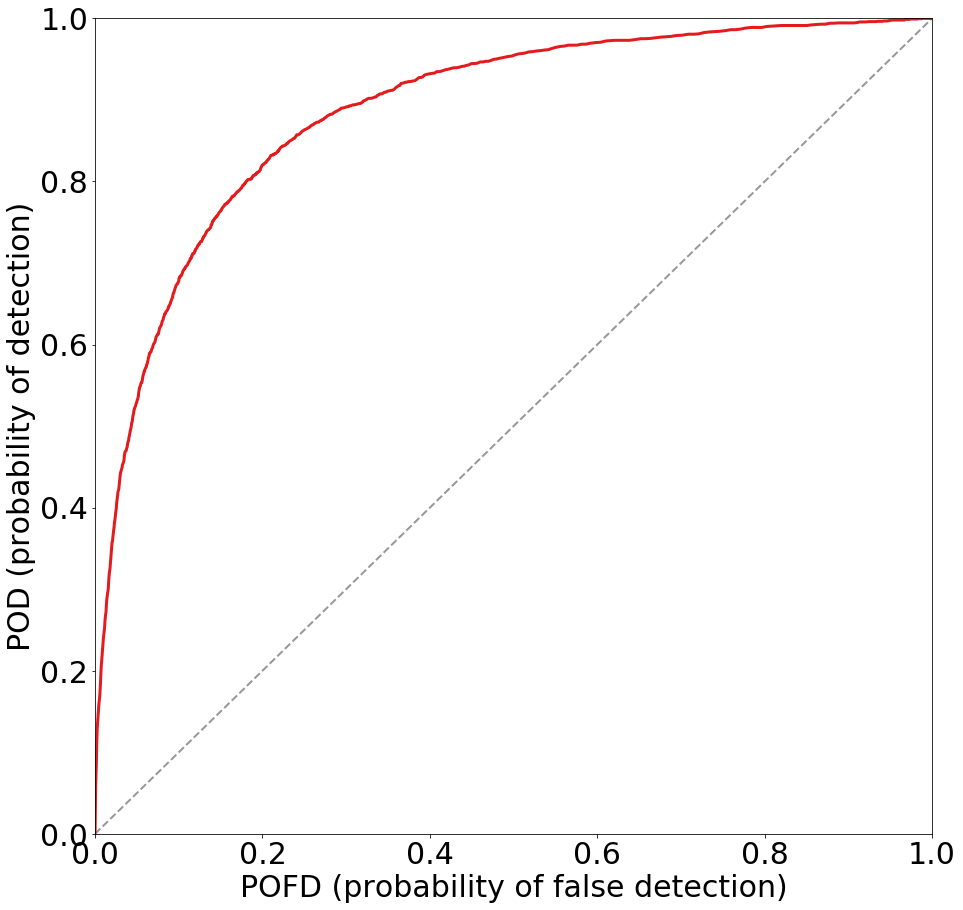

Area under ROC curve: 0.8874
Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/validation/roc_curve.jpg"...


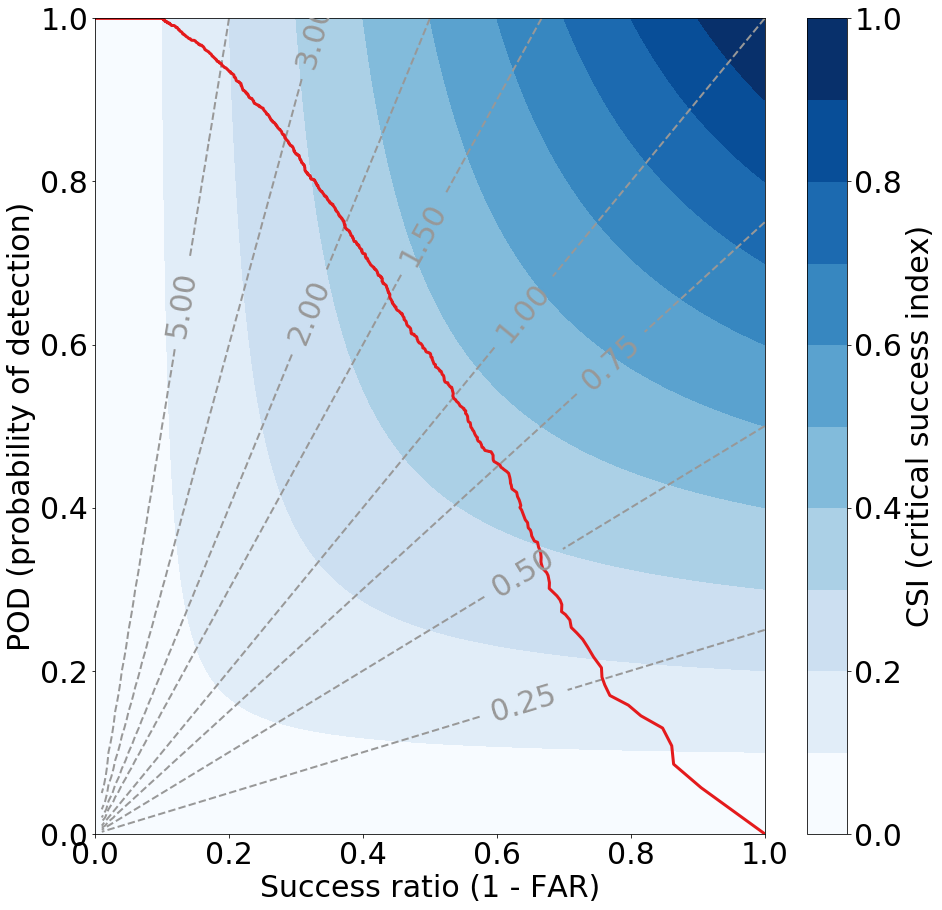

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/validation/performance_diagram.jpg"...


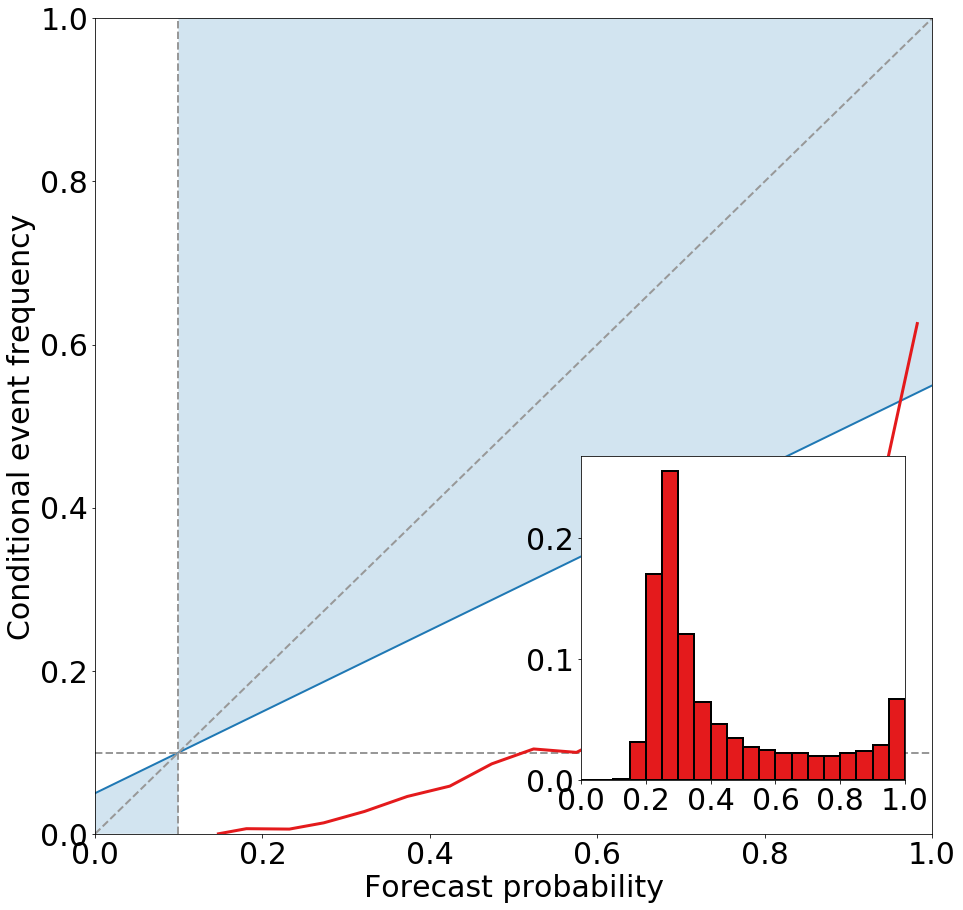

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/validation/attributes_diagram.jpg"...


**************************************************




In [21]:
validation_image_dict = read_many_image_files(validation_file_names)
print(SEPARATOR_STRING)

validation_dir_name = '{0:s}/validation'.format(output_dir_name)
evaluate_cnn(
    model_object=model_object, image_dict=validation_image_dict,
    model_metadata_dict=model_metadata_dict,
    output_dir_name=validation_dir_name)
print(SEPARATOR_STRING)

Run permutation test on validation data.

In [22]:
permutation_dir_name = '{0:s}/permutation_test'.format(output_dir_name)
main_permutation_file_name = '{0:s}/permutation_results.p'.format(
    permutation_dir_name)

permutation_dict = permutation_test_for_cnn(
    model_object=model_object, image_dict=validation_image_dict,
    model_metadata_dict=model_metadata_dict,
    output_pickle_file_name=main_permutation_file_name)
print(SEPARATOR_STRING)

Applying model to examples 0-999 of 25392...
Applying model to examples 1000-1999 of 25392...
Applying model to examples 2000-2999 of 25392...
Applying model to examples 3000-3999 of 25392...
Applying model to examples 4000-4999 of 25392...
Applying model to examples 5000-5999 of 25392...
Applying model to examples 6000-6999 of 25392...
Applying model to examples 7000-7999 of 25392...
Applying model to examples 8000-8999 of 25392...
Applying model to examples 9000-9999 of 25392...
Applying model to examples 10000-10999 of 25392...
Applying model to examples 11000-11999 of 25392...
Applying model to examples 12000-12999 of 25392...
Applying model to examples 13000-13999 of 25392...
Applying model to examples 14000-14999 of 25392...
Applying model to examples 15000-15999 of 25392...
Applying model to examples 16000-16999 of 25392...
Applying model to examples 17000-17999 of 25392...
Applying model to examples 18000-18999 of 25392...
Applying model to examples 19000-19999 of 25392...
Appl

Applying model to examples 12000-12999 of 25392...
Applying model to examples 13000-13999 of 25392...
Applying model to examples 14000-14999 of 25392...
Applying model to examples 15000-15999 of 25392...
Applying model to examples 16000-16999 of 25392...
Applying model to examples 17000-17999 of 25392...
Applying model to examples 18000-18999 of 25392...
Applying model to examples 19000-19999 of 25392...
Applying model to examples 20000-20999 of 25392...
Applying model to examples 21000-21999 of 25392...
Applying model to examples 22000-22999 of 25392...
Applying model to examples 23000-23999 of 25392...
Applying model to examples 24000-24999 of 25392...
Applying model to examples 25000-25391 of 25392...


--------------------------------------------------


Resulting cost = 8.9798e-01
Trying predictor "temperature_kelvins" at step 2 of permutation test...


--------------------------------------------------


Applying model to examples 0-999 of 25392...
Applying model to examples 1000

Applying model to examples 23000-23999 of 25392...
Applying model to examples 24000-24999 of 25392...
Applying model to examples 25000-25391 of 25392...


--------------------------------------------------


Resulting cost = 9.3035e-01

Best predictor = "reflectivity_dbz" ... new cost = 9.3035e-01

Writing results to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/permutation_test/permutation_results.p"...


**************************************************




Plot results of Breiman (single-pass) version of permutation test.  The most important predictor is at the top; the least important predictor is at the bottom.  For predictor x, the value shown is the cross-entropy when only x is permuted.

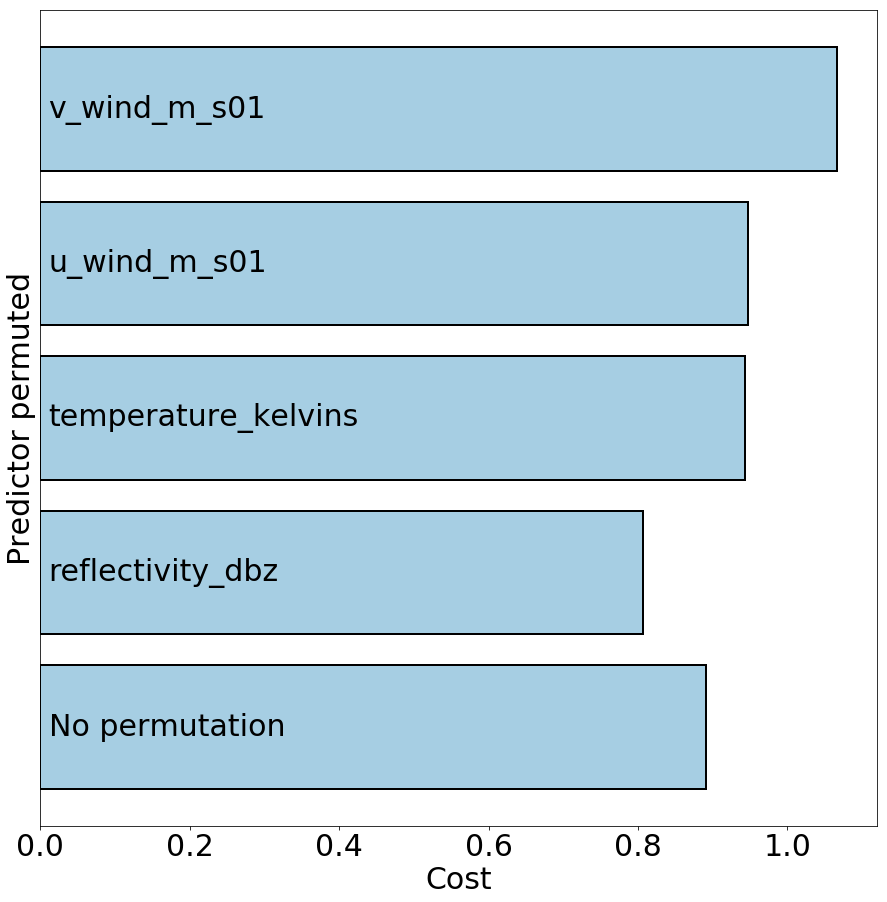

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/permutation_test/breiman_results.jpg"...


In [31]:
breiman_file_name = '{0:s}/breiman_results.jpg'.format(permutation_dir_name)
plot_breiman_results(
    result_dict=permutation_dict, output_file_name=breiman_file_name,
    plot_percent_increase=False)

Plot results of Lakshmanan (multi-pass) version of permutation test.  Again, the most (least) important predictor is at the top (bottom).  The "cost" for predictor x is the cross-entropy when predictor x and all those above it are permuted.

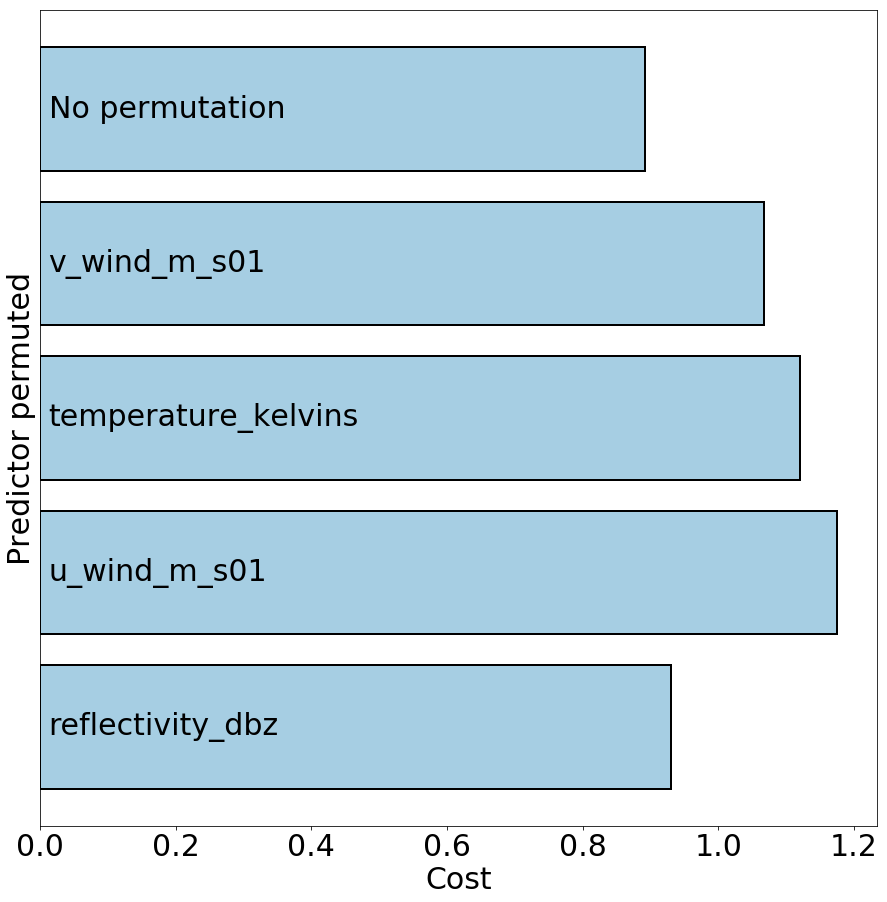

Saving figure to: "/home/ryan.lagerquist/Downloads/ams2019_short_course/permutation_test/lakshmanan_results.jpg"...


In [32]:
lakshmanan_file_name = '{0:s}/lakshmanan_results.jpg'.format(
    permutation_dir_name)
plot_lakshmanan_results(
    result_dict=permutation_dict, output_file_name=lakshmanan_file_name,
    plot_percent_increase=False)